### Import packages:

In [1]:
# import dva_sdhdf_combine
import imp
import os
import subprocess
import h5py
import numpy as np
from astropy.time import Time
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import HourLocator as HourLocator
from matplotlib.dates import MinuteLocator as MinuteLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy import units as u
from astropy.time import TimeDelta
from ipywidgets import interact

#### Change the directory to where the files are located" ####
directory = '../DVA/Data_Files/Mini_survey_scans/'

### Change the scan details to your current scan
df = 0.5        
dt = 6.9444431574083865e-06

#TODO: actually do the scan properties definition in the beginning
##############################################################

### Import Leo's functions for RFI Excision

In [2]:
# in_power_array        Input power array (RR, LL, reRL, imRL) at a single frequency
# numt                  Number of time points to include in the 'window' in which the standard deviation is calculated
# threshold             Array of standard deviation thresholds to use in each stage of the RFI excision 

def Is_RFI(in_power_array, threshold, idx, interval_start, interval_end):
    retVal = False
    in_power_mean = np.nanmean(in_power_array[interval_start:interval_end])
    in_power_std = np.nanstd(in_power_array[interval_start:interval_end])
    if abs(in_power_array[idx]) > abs(in_power_mean)+threshold*in_power_std:
        retVal = True
    return retVal
    
def Find_Slope(array, idx):
    return array[idx+2] - array[idx]

def Get_RFI_Duration(in_power_array, interval_start, interval_end):  #NOTE: This approach might have issues if the interval has a nan on it
    #Find the first slope
    first_slope = Find_Slope(in_power_array, interval_start)
    #Initiate the RFI interval indexes at the boundaries of the set
    RFI_start = interval_start
    RFI_end = interval_end
    #Initiate as the fastest rise & fall
    steepest_rise = first_slope
    steepest_fall = first_slope 
    start_idx = interval_start + 1  # Ignores the first slope (since it's already calculated)
    end_idx = interval_end - 2      # Avoids overflowing (since each slope is calculated 2 indexes ahead)
    for idx in range(start_idx, end_idx):
        current_slope = Find_Slope(in_power_array, idx)
        if(current_slope >  steepest_rise):
            steepest_rise = current_slope
            RFI_start = idx
        elif(current_slope < steepest_fall):
            steepest_fall = current_slope
            RFI_end = idx + 2
    return (RFI_end - RFI_start)

def Get_RFI_Duration(in_power_array, interval_start, interval_end):  #NOTE: This approach might have issues if the interval has a nan on it
    #Find the first slope
    first_slope = Find_Slope(in_power_array, interval_start)
    #Initiate the RFI interval indexes at the boundaries of the set
    RFI_start = interval_start
    RFI_end = interval_end
    #Initiate as the fastest rise & fall
    steepest_rise = first_slope
    steepest_fall = first_slope 
    start_idx = interval_start + 1  # Ignores the first slope (since it's already calculated)
    end_idx = interval_end - 2      # Avoids overflowing (since each slope is calculated 2 indexes ahead)
    for idx in range(start_idx, end_idx):
        current_slope = Find_Slope(in_power_array, idx)
        if(current_slope >  steepest_rise):
            steepest_rise = current_slope
            RFI_start = idx
        elif(current_slope < steepest_fall):
            steepest_fall = current_slope
            RFI_end = idx + 2
    return (RFI_end - RFI_start)

def Get_Polarized_Set(reRL_set, imRL_set, freq_measured):
    polarized = []
    reRL_set_in_use = reRL_set[:,freq_measured]    #TODO: maybe I can try making something general that I can scan over all frequencies
    imRL_set_in_use = imRL_set[:,freq_measured]
    for i,j in zip(reRL_set_in_use,imRL_set_in_use):
        PI = np.sqrt((i**2)+(j**2))
        polarized.append(PI)
    return np.array(polarized)

def Get_RFI_Excision_Mask(time_array,in_power_array,time_steps,threshold):
    # for freq in range(0, len(power_array)):     
    mask = np.zeros([len(time_array)])  #Initiate empty mask
    start_idx = time_steps
    end_idx = len(time_array)-time_steps              
    for idx in range(start_idx, end_idx):
        if Is_RFI(in_power_array, threshold, idx, idx - time_steps, idx + time_steps):
            RFI_duration = Get_RFI_Duration(in_power_array, idx - time_steps, idx + time_steps)
            mask[idx - RFI_duration:idx + RFI_duration] = 1
    return(mask)

def Apply_RFI_Excision_Mask(mask, input_array):
    masked_copy = input_array.copy()
    for idx in range(0, len(input_array)-1):
        if(mask[idx] == 1):
            masked_copy[idx] = np.nan
    return(masked_copy)

def Get_RFI_Excision_Freq_Mask(freq_array, power_spectrum_array, freq_steps, slope_threshold):
    interval_start = 0
    first_slope = Find_Slope(power_spectrum_array, interval_start)
    second_slope = Find_Slope(power_spectrum_array, interval_start + 1)


# NEW RFI_Excision functions (WORK IN PROGRESS)

In [3]:
# power_array has time and frequency
#TODO: Count how long it takes to run this for a single frequency 

def Find_Slope(array, idx):
    return array[idx+2] - array[idx]

def Is_Time_RFI(in_power_array, threshold, idx, interval_start, interval_end):
    retVal = False
    in_power_mean = np.nanmean(in_power_array[interval_start:interval_end])
    in_power_std = np.nanstd(in_power_array[interval_start:interval_end])
    if abs(in_power_array[idx]) > abs(in_power_mean)+threshold*in_power_std:
        retVal = True
    return retVal

#TODO: Change the name of the function below to Find_RFI_Excision_Regions, or make a wrapper function to go through all the frequencies

# def Get_RFI_Excision_Mask(time_array, power_array, time_steps, slope_threshold, starting_frequency): #TODO: The final function will not take starting_frequency as an input, I'll loop through all frequencies
#     confirmed_RFI_events = Find_RFI_Excision_Intervals(time_array, power_array, time_steps, slope_threshold, starting_frequency)
#     mask = []
#     #TODO: Populate mask
#     return mask
def RFI_Time_Scan(time_array, single_freq_power_array, time_steps, threshold):
    possible_RFI_events = []
    start_idx = time_steps
    end_idx = len(time_array)-time_steps              
    for idx in range(start_idx, end_idx):
        if Is_Time_RFI(single_freq_power_array, threshold, idx, idx - time_steps, idx + time_steps):
            RFI_duration = Get_RFI_Duration(single_freq_power_array, idx - time_steps, idx + time_steps)
            possible_RFI_events.append([idx, RFI_duration])
    return(possible_RFI_events)

def Spectrum_RFI_Start_Found(spectrum_power_array, idx, slope_threshold):
    RFI_Start_Found = False
    current_slope = Find_Slope(spectrum_power_array, idx)
    next_slope = Find_Slope(spectrum_power_array, idx+3)
    if((current_slope <= slope_threshold) and (next_slope >= slope_threshold)):
        RFI_Start_Found = True
    return RFI_Start_Found

def Spectrum_RFI_End_Found(spectrum_power_array, idx, slope_threshold):
    RFI_End_Found = False
    current_slope = Find_Slope(spectrum_power_array, idx)
    next_slope = Find_Slope(spectrum_power_array, idx+3)
    if((current_slope <= (-1)*slope_threshold) and (next_slope >= (-1)*slope_threshold)):
        RFI_End_Found = True
    return RFI_End_Found

def RFI_Spectrum_Scan(spectrum_power_array, freq_measured, slope_threshold): #NOTE: This might be an issue if I have a nan value on my array
    scan_bandwidth = 50 #[MHz]
    start_idx = int(freq_measured - int((scan_bandwidth/df)/2))  #This changes the bandwidth from MHz to idxes
    end_idx = int(freq_measured + int((scan_bandwidth/df)/2))
    RFI_confirmed = False
    RFI_spectral_thickness = 0
    for rfi_start_idx in range(start_idx, end_idx):                                             #Scan over the entire bandwith interval
        if(Spectrum_RFI_Start_Found(spectrum_power_array, rfi_start_idx, slope_threshold)):     #If I found the starting pattern
            for rfi_end_idx in range(rfi_start_idx, end_idx):                                   #Finish looking at the bandwidth interval looking for the end
                if(Spectrum_RFI_End_Found(spectrum_power_array, rfi_end_idx, slope_threshold)):     #If I found the ending pattern
                    RFI_confirmed = True                                                                #If there's a start and end, I'll confirm that event as RFI
                    RFI_spectral_thickness = (rfi_end_idx - rfi_start_idx)
            if(RFI_confirmed):                                                                          #and stop looping throught the interval for efficiency
                break
        if(RFI_confirmed):
            break                           #TODO: this looks ugly AF, I should be using else and continue to clean this thing
    return RFI_confirmed, RFI_spectral_thickness
    
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def Find_RFI_Regions(time_array, power_array, time_steps, slope_threshold, starting_frequency):
    confirmed_RFI_events = []
    # mask = np.zeros([len(time_array)])  #Initiate empty mask
    # freq_measured = np.min(np.where(abs(freq-starting_frequency)<df))#[0][0] #[MHz]
    freq_idx = find_nearest_idx(freq, starting_frequency)
    freq_measured = freq[freq_idx]
    print("input starting frequency:", starting_frequency)
    print("closest frequency measured:", freq_measured)
    
    gaussian_threshold = 4  #Arbitrary, changed as needed
    possible_RFI_events = RFI_Time_Scan(time_array, power_array[:, freq_idx], time_steps, gaussian_threshold) #Returns an array with [idx, RFI_idx_duration] of candidate RFI signals
    print("possible RFI events:", len(possible_RFI_events))
    for event in range(len(possible_RFI_events)):
        dt = (time_array[1] - time_array[0])
        RFI_event_time_idx = possible_RFI_events[event][0]              #in [idxes]
        RFI_event_duration = possible_RFI_events[event][1]*(dt)         #in [time_units]
        # print("event", event, "happens at", time_array[possible_RFI_events[event][0]])
        #Confirms by doing a small spectrum scan
        RFI_event_confirmation_result = RFI_Spectrum_Scan(power_array[RFI_event_time_idx, :], freq_measured, slope_threshold) #Returns [bool, idx_spectral_thickness]
        if(RFI_event_confirmation_result[0]):
            confirmed_RFI_events.append([freq_measured, RFI_event_confirmation_result[1]*df, time_array[possible_RFI_events[event][0]], RFI_event_duration])
    print("confirmed RFI events:", len(confirmed_RFI_events))
    return confirmed_RFI_events #An Array with [freq, df, time, dt] for each confirmed RFI

###################################################################################################################################################################
# in_power_array        Input power array (RR, LL, reRL, imRL) at a single frequency TODO: This needs to change to 
# numt                  Number of time points to include in the 'window' in which the standard deviation is calculated
# threshold             Array of standard deviation thresholds to use in each stage of the RFI excision 

def Get_Polarized_Set(reRL_set, imRL_set, freq_measured):
    polarized = []
    reRL_set_in_use = reRL_set[:,freq_measured]    #TODO: maybe I can try making something general that I can scan over all frequencies
    imRL_set_in_use = imRL_set[:,freq_measured]
    for i,j in zip(reRL_set_in_use,imRL_set_in_use):
        PI = np.sqrt((i**2)+(j**2))
        polarized.append(PI)
    return np.array(polarized)


def Apply_RFI_Excision_Mask(mask, input_array): #TODO: This needs to be updated to implement all frequencies
    
    masked_copy = input_array.copy()
    for idx in range(0, len(input_array)-1):
        if(mask[idx] == 1):
            masked_copy[idx] = np.nan
    return(masked_copy)



### Read in the file listing the scan start and stop times:

In [4]:
scan_num = []    # The scan id number
scan_start = []  # Start time of the scan (UTC)
scan_stop = []   # Stop time of the scan (UTC)

# Read in the data and store it in arrays:
with open(directory+'azscans_out_mini_survey_good.txt') as fp:
    for line in fp:       
        scan_num.append(int(line.split()[0]))
        scan_start.append(line.split()[1]+'T'+line.split()[2][0:12])
        scan_stop.append(line.split()[3]+'T'+line.split()[4][0:12])

# Print out the scan numbers with their start and stop times:
for i in range(0,len(scan_num)):
    print(scan_num[i],scan_start[i],scan_stop[i])

# Convert start and stop times to Modified Julian Day (MJD).
# This is needed for plotting and for selecting out data collected
# between particular times:
scan_start_mjd = Time(scan_start, format='isot',scale='utc').mjd
scan_stop_mjd  = Time(scan_stop,  format='isot',scale='utc').mjd

2 2022-05-18T02:19:57.799 2022-05-18T02:37:59.622
3 2022-05-18T02:42:23.768 2022-05-18T03:00:25.975
4 2022-05-18T03:04:50.203 2022-05-18T03:22:52.085
5 2022-05-18T03:27:16.790 2022-05-18T03:45:18.698
6 2022-05-18T03:49:43.137 2022-05-18T04:07:45.238
7 2022-05-18T04:12:09.273 2022-05-18T04:30:11.468
8 2022-05-18T04:34:35.727 2022-05-18T04:52:37.999
9 2022-05-18T04:57:02.029 2022-05-18T05:15:04.069
10 2022-05-18T05:19:28.248 2022-05-18T05:37:30.300
11 2022-05-18T05:41:54.444 2022-05-18T05:59:56.440
12 2022-05-18T06:04:20.926 2022-05-18T06:22:22.771
13 2022-05-18T06:26:47.173 2022-05-18T06:44:49.373
14 2022-05-18T06:49:13.296 2022-05-18T07:07:15.002
15 2022-05-18T07:11:39.591 2022-05-18T07:29:41.713
16 2022-05-18T07:34:06.119 2022-05-18T07:52:07.963
17 2022-05-18T07:56:32.414 2022-05-18T08:14:34.333
18 2022-05-18T08:18:58.755 2022-05-18T08:37:00.654
19 2022-05-18T08:41:24.975 2022-05-18T08:59:27.324
20 2022-05-18T09:03:51.078 2022-05-18T09:21:52.714
21 2022-05-18T09:26:17.720 2022-05-18T0

### Read in scan files and stitch them together:
#### Note: this will take several minutes to run if stitching together all 3 days of data

In [5]:
t_set = []
az_set = []
dec_set = []
ra_set = []
el_set = []

# Use one of the scans to get the list of frequencies:
file = h5py.File(directory+'Mini_survey_scan_002.h5','r')
freq = file['data']['beam_0']['band_SB0']['frequency'][:]/1e6

# Create empty arrays for the power data:
RR_set_raw = np.empty([0,len(freq)])
LL_set_raw = np.empty([0,len(freq)])
reRL_set_raw = np.empty([0,len(freq)])
imRL_set_raw = np.empty([0,len(freq)])

# Loop through all the scans in the "scan_num" list:
for i in range(2,13):   #NOTE: This is hardcoded because I only have a few files downloaded locally
    
    # select the file:
    file = h5py.File(directory+'Mini_survey_scan_'+f"{i:03}"+'.h5','r')
    print(file)
    
    # access the correct location in the file structure:
    dataset = file['data']['beam_0']['band_SB0']['scan_0']
    
    # Add the position and time data to the corresponding arrays:
    dec_set = np.concatenate([dec_set,dataset['metadata']['declination']])
    ra_set = np.concatenate([ra_set,dataset['metadata']['right_ascension']])
    el_set = np.concatenate([el_set,dataset['metadata']['elevation']])
    az_set = np.concatenate([az_set,dataset['metadata']['azimuth']])
    t_set = np.concatenate([t_set,dataset['metadata']['utc']])
    
    # Add the spectrometer power data to the corresponding arrays:
    RR_set_raw = np.concatenate([RR_set_raw,dataset['data'][:,0,:]],axis=0)
    LL_set_raw = np.concatenate([LL_set_raw,dataset['data'][:,1,:]],axis=0)
    reRL_set_raw = np.concatenate([reRL_set_raw,dataset['data'][:,2,:]],axis=0)
    imRL_set_raw = np.concatenate([imRL_set_raw,dataset['data'][:,3,:]],axis=0)
    

<HDF5 file "Mini_survey_scan_002.h5" (mode r)>
<HDF5 file "Mini_survey_scan_003.h5" (mode r)>
<HDF5 file "Mini_survey_scan_004.h5" (mode r)>
<HDF5 file "Mini_survey_scan_005.h5" (mode r)>
<HDF5 file "Mini_survey_scan_006.h5" (mode r)>
<HDF5 file "Mini_survey_scan_007.h5" (mode r)>
<HDF5 file "Mini_survey_scan_008.h5" (mode r)>
<HDF5 file "Mini_survey_scan_009.h5" (mode r)>
<HDF5 file "Mini_survey_scan_010.h5" (mode r)>
<HDF5 file "Mini_survey_scan_011.h5" (mode r)>
<HDF5 file "Mini_survey_scan_012.h5" (mode r)>


### Make a degrees (instead of hours) version of RA, and an MJD version of the time array:

In [6]:
ra_set_deg = ra_set*360./24.
t_plt = Time(t_set, format='isot',scale='utc').mjd

### Read in the times when the noise source was turned on, and mask this out in the power data:

In [7]:
t_noise1 = []
t_noise2 = []

with open(directory+'noise_mini_survey_part1.txt') as fp:
    for line in fp:       
        t_noise1.append(line.split()[0]+'T'+line.split()[1][0:12])
        t_noise2.append(line.split()[2]+'T'+line.split()[3][0:12])

t_noise1_plt = Time(t_noise1, format='isot',scale='utc').mjd
t_noise2_plt = Time(t_noise2, format='isot',scale='utc').mjd

# Buffer time (in seconds) around data points where noise source
# is being turned on or off:
t_buff = 1./(3600.*24.)

# Make copies of the arrays in which noise will be masked out:
RR_set = RR_set_raw.copy()
LL_set = LL_set_raw.copy()
reRL_set = reRL_set_raw.copy()
imRL_set = imRL_set_raw.copy()

print(len(LL_set))

# #Extract masks TODO: Currenct my Get_RFI_Excision_Mask only works for a single frequency
# time_steps = 30
# threshold = 4
# RR_mask = Get_RFI_Excision_Mask(t_plt, RR_set, time_steps, threshold)
# LL_mask = Get_RFI_Excision_Mask(t_plt, LL_set, time_steps, threshold)
# reRL_mask = Get_RFI_Excision_Mask(t_plt, reRL_set, time_steps, threshold)
# imRL_mask = Get_RFI_Excision_Mask(t_plt, imRL_set, time_steps, threshold)

# Loop through times when noise source was turned on and replace
# data values with NaN at those times:
for i in range(0,len(t_noise1)):
    wnoise_sub_rem = np.where( (t_plt >= t_noise1_plt[i]-t_buff) & (t_plt <= t_noise2_plt[i]+t_buff) )[0]
    RR_set[wnoise_sub_rem,:] = np.nan
    LL_set[wnoise_sub_rem,:] = np.nan
    reRL_set[wnoise_sub_rem,:] = np.nan
    imRL_set[wnoise_sub_rem,:] = np.nan

20600


### Plot the scans in RA/dec at a particular frequency:

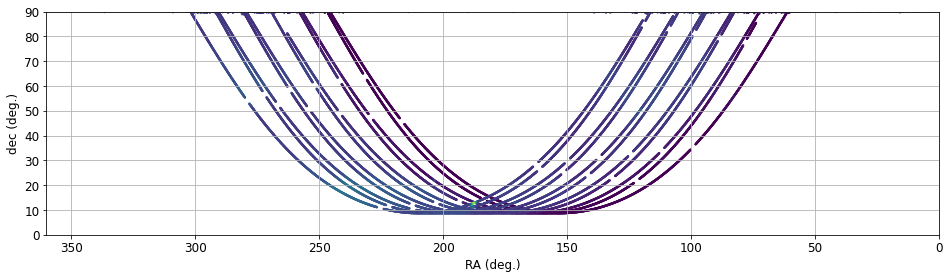

In [8]:
### Pick frequency to plot: ############
freq_plt = 800. # in MHz
########################################

w = np.where(abs(freq-freq_plt)<df)[0][0]

fs = 12
fig1, axs = plt.subplots(1,1,figsize=(16,6))

axs.scatter(ra_set_deg, dec_set,s=2,c=10.*np.log10(LL_set[:,w]),cmap='viridis',vmin=70.5, vmax=71.5)
axs.set_xlabel('RA (deg.)',fontsize=fs)
axs.set_ylabel('dec (deg.)',fontsize=fs)
axs.tick_params(axis="x", labelsize=fs)
axs.tick_params(axis="y", labelsize=fs)
axs.set_xlim(360,0)
axs.set_ylim(0,90)
axs.set(aspect='equal')
axs.grid()

In [9]:
#TODO: Maybe I could create an interactive plot that if I tick a box I could flip to a power vs frequency plot or power vs time plot
#I should have a knob for changing frequency and time
#I could also introduce a vertical line to show which slice I'm currently at to help navigating through the data
df = freq[1]-freq[0]

def DVA_Waterfall_View(scan_id, show_all_scans):
    #TODO: Add another DVA_Waterfall interactive_function such that I can change between LL_Set, RR_set, etc...
    power_min = 70
    power_max = 78
    if not show_all_scans:
        w = np.where(np.array(scan_num) == scan_id)[0][0]
        t1_plt = scan_start_mjd[w]
        t2_plt = scan_stop_mjd[w]
        ######################################
        wplot = np.where( (t_plt <= t2_plt) & (t_plt >= t1_plt) )

        time_plot = t_plt[wplot]

        fig,axs = plt.subplots(1,1,figsize=(15,10)) 
        fs = 16

        im = axs.imshow(10.*np.log10(LL_set[wplot].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
                    extent=[time_plot[0],time_plot[-1],freq[0],freq[-1]])

        divider = make_axes_locatable(axs)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.ax.tick_params(labelsize=fs) 
        cbar.set_label('Power (dB)', fontsize=fs)

        axs.set_xlim(time_plot[0],time_plot[-1])
        axs.set_ylim(freq[0],freq[-1])
        axs.tick_params(axis='both', labelsize=fs)
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs.set_xlabel('Time (UTC)',fontsize=fs)        
        axs.set_ylabel('Frequency (MHz)',fontsize=fs)
    else:
        fig,axs = plt.subplots(1,1,figsize=(15,10)) 
        fs = 16

        im = axs.imshow(10.*np.log10(LL_set.T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
                    extent=[t_plt[0],t_plt[-1],freq[0],freq[-1]])

        divider = make_axes_locatable(axs)
        cax = divider.append_axes('right', size='2%', pad=0.05)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.ax.tick_params(labelsize=fs) 
        cbar.set_label('Power (dB)', fontsize=fs)

        axs.set_xlim(t_plt[0],t_plt[-1])
        axs.set_ylim(freq[0],freq[-1])
        axs.tick_params(axis='both', labelsize=fs)
        axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs.set_xlabel('Time (UTC)',fontsize=fs)        
        axs.set_ylabel('Frequency (MHz)',fontsize=fs)

def DVA_Cross_Sections(scan_id, freq_chosen, time_idx, freq_cross_section):
    freq_measured = np.where(abs(freq-freq_chosen)<df)[0][0]
    
    w = np.where(np.array(scan_num) == scan_id)[0][0]
    t1 = scan_start[w]
    t2 = scan_stop[w]
    t1_plt = scan_start_mjd[w]
    t2_plt = scan_stop_mjd[w]
    
    wplot = np.where((t_plt>=t1_plt) & (t_plt<=t2_plt))
    
    polarized_set = Get_Polarized_Set(reRL_set, imRL_set, freq_measured)
    time_steps = 30
    threshold = 4
    polarized_mask = Get_RFI_Excision_Mask(t_plt[wplot], polarized_set[wplot], time_steps, threshold)
    LL_set_with_polarized_mask = Apply_RFI_Excision_Mask(polarized_mask, LL_set[wplot])
    
    fs = 12
    fig, axs = plt.subplots(1,1,figsize=(12,6))
    axs.scatter(ra_set_deg[wplot], dec_set[wplot],s=2,c=10.*np.log10(LL_set[wplot,freq_measured]),
                cmap='viridis',vmin=70.5, vmax=71.5)
    axs.set_xlabel('RA (deg.)',fontsize=fs)
    axs.set_ylabel('dec (deg.)',fontsize=fs)
    axs.tick_params(axis="x", labelsize=fs)
    axs.tick_params(axis="y", labelsize=fs)
    axs.set_xlim(360,0)
    axs.set_ylim(0,90)
    axs.set(aspect='equal')
    axs.grid()
    
    
    fig,axs1 = plt.subplots(1,1,figsize=(16,6))  
    # TODO: use the log of LL_set_clean

    if(freq_cross_section):
        time_chosen = int(time_idx/len(LL_set_with_polarized_mask)) #NOTE: I have no idea what 100 actually means
        axs1.plot(freq, LL_set_with_polarized_mask[time_chosen,:], label = 'LL_set with polarized mask')   #I need to plot freq vs power
        axs1.vlines(freq_chosen, 0 , 100e9, color = 'red')
        axs1.set_ylim(0, np.max(LL_set_with_polarized_mask[time_chosen,:]))
        axs1.set_xlabel('Frequency',fontsize=fs)
        axs1.set_ylabel('Power',fontsize=fs)
    else:
        # axs.plot(t_plt_one_scan,wplot[0])
        axs1.plot(t_plt[wplot], LL_set[wplot,freq_measured][0], label = 'LL_set unmasked RFI')
        axs1.plot(t_plt[wplot], LL_set_with_polarized_mask[:,freq_measured], label = 'LL_set with polarized mask')
        axs1.plot(t_plt[wplot], polarized_set[wplot], label = 'polarized set')
        axs1.set_ylim(0, np.nanmax(LL_set_with_polarized_mask[:,freq_measured]))
        axs1.vlines(t_plt[time_idx], 0 , 100e9, color = 'red')

        axs1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        axs1.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
        axs1.set_xlabel('Time (UTC)',fontsize=fs)
        axs1.set_ylabel('Power',fontsize=fs)
        axs1.legend()

def DVA_Visualization(waterfall_enabled):             #TODO: use t_plt, polarized_plot, ymasked as inputs on this function so I can use it at different locations
    if waterfall_enabled:
        interact(DVA_Waterfall_View, scan_id = (2,12), show_all_scans = False)
    else:
        interact(DVA_Cross_Sections, scan_id = (2,12), freq_chosen = (350, 1000, df), freq_cross_section = False, time_idx = (0,len(t_plt)-1))


interact(DVA_Visualization, waterfall_enabled = True)

#TODO: I could try to figure out if I could zoom in on time, and adjust the dec vs RA plot accordingly
#TODO: plot power in DB

interactive(children=(Checkbox(value=True, description='waterfall_enabled'), Output()), _dom_classes=('widget-…

<function __main__.DVA_Visualization(waterfall_enabled)>

input starting frequency: 850
closest frequency measured: 849.75
possible RFI events: 4
confirmed RFI events: 4


Text(0, 0.5, 'Frequency (MHz)')

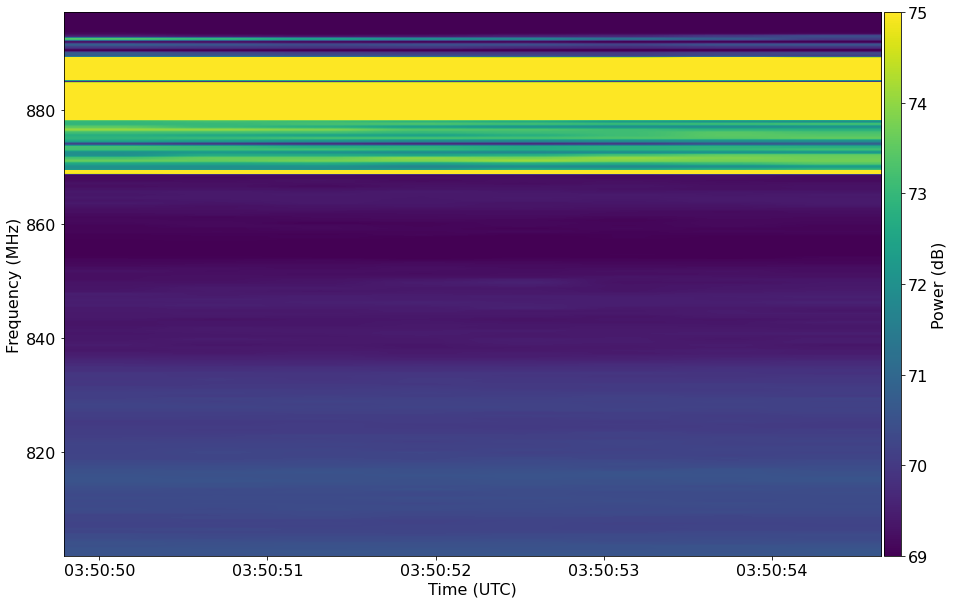

In [10]:
time_steps = 30
slope_threshold = 10000 #This number needs to be adjusted in order to correctly filter out non-RFI NOTE: 5000 works
LL_Set_RFI_Regions = Find_RFI_Regions(t_plt, LL_set, time_steps, slope_threshold, 850) #Returns an array of [freq, df, time, dt]

first_RFI_region = LL_Set_RFI_Regions[3]

#Try plotting the first RFI_Region

power_min = 69
power_max = 75

t1_plt = first_RFI_region[2] - first_RFI_region[3]
t2_plt = first_RFI_region[2] + first_RFI_region[3]

freq1 = first_RFI_region[0] - first_RFI_region[1]
freq2 = first_RFI_region[0] + first_RFI_region[1]
######################################
rfi_start_idx = find_nearest_idx(t_plt, t1_plt)
rfi_end_idx = find_nearest_idx(t_plt, t2_plt)

f_plt_start_idx = find_nearest_idx(freq, freq1)
f_plt_end_idx = find_nearest_idx(freq, freq2)

RFI_duration_time = t_plt[rfi_start_idx: rfi_end_idx]

RFI_freq_bandwith = freq[f_plt_start_idx: f_plt_end_idx]


fig,axs = plt.subplots(1,1,figsize=(15,10)) 
fs = 16

im = axs.imshow(10.*np.log10(LL_set[rfi_start_idx: rfi_end_idx,f_plt_start_idx: f_plt_end_idx].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
            extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)

axs.set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
# axs.set_ylim(RFI_freq_bandwith[0],RFI_freq_bandwith[-1])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)

#TODO: I don't think it's clear which region this method is flaggin as RFI


input starting frequency: 900
closest frequency measured: 899.75
possible RFI events: 2
confirmed RFI events: 2


Text(0, 0.5, 'Frequency (MHz)')

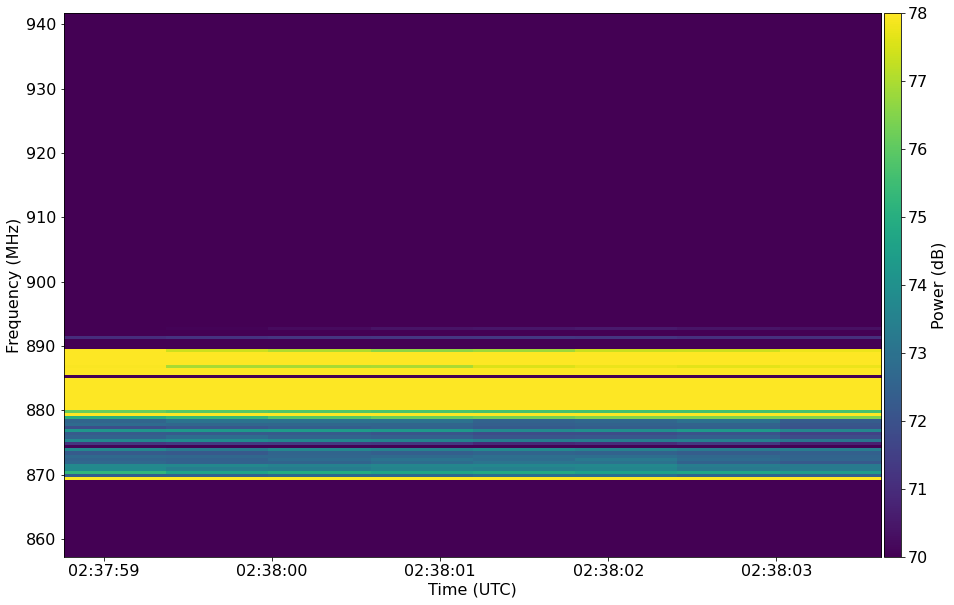

In [11]:
time_steps = 30
slope_threshold = 10000 #This number needs to be adjusted in order to correctly filter out non-RFI NOTE: 5000 works
LL_Set_RFI_Regions = Find_RFI_Regions(t_plt, LL_set, time_steps, slope_threshold, 900) #Returns an array of [freq, df, time, dt]

first_RFI_region = LL_Set_RFI_Regions[0]

#Try plotting the first RFI_Region

power_min = 70
power_max = 78

t1_plt = first_RFI_region[2] - first_RFI_region[3]
t2_plt = first_RFI_region[2] + first_RFI_region[3]

freq1 = first_RFI_region[0] - first_RFI_region[1]
freq2 = first_RFI_region[0] + first_RFI_region[1]
######################################
rfi_start_idx = find_nearest_idx(t_plt, t1_plt)
rfi_end_idx = find_nearest_idx(t_plt, t2_plt)

f_plt_start_idx = find_nearest_idx(freq, freq1)
f_plt_end_idx = find_nearest_idx(freq, freq2)

RFI_duration_time = t_plt[rfi_start_idx: rfi_end_idx]

RFI_freq_bandwith = freq[f_plt_start_idx: f_plt_end_idx]


fig,axs = plt.subplots(1,1,figsize=(15,10)) 
fs = 16

im = axs.imshow(10.*np.log10(LL_set[rfi_start_idx: rfi_end_idx,f_plt_start_idx: f_plt_end_idx].T),aspect='auto',vmin=power_min,vmax=power_max,origin='lower',
            extent=[RFI_duration_time[0],RFI_duration_time[-1],RFI_freq_bandwith[0],RFI_freq_bandwith[-1]])

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='2%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fs) 
cbar.set_label('Power (dB)', fontsize=fs)

axs.set_xlim(RFI_duration_time[0],RFI_duration_time[-1])
# axs.set_ylim(RFI_freq_bandwith[0],RFI_freq_bandwith[-1])
axs.tick_params(axis='both', labelsize=fs)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
axs.fmt_xdata = mdates.DateFormatter('%H:%M:%S')
axs.set_xlabel('Time (UTC)',fontsize=fs)        
axs.set_ylabel('Frequency (MHz)',fontsize=fs)

#TODO: I don't think it's clear which region this method is flaggin as RFI
